In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math

import density_contour

# plot inline figures
%matplotlib inline 
# to make saved pdf figures have real text, not outlines
matplotlib.rcParams['pdf.fonttype'] = 42; matplotlib.rcParams['ps.fonttype'] = 42

## Import data into Pandas

In [3]:
# read in point loma data
pldatapath="/Users/zanejobe/Dropbox/1 PointLomaRosieCABR/Compilation_Database/Digitize/PLdata/PointLomaShp_2019/"
plfilename="aaPLData_Thickness_ThinningRate_Distance_Lithology_Element.txt"
pl = pd.read_csv(pldatapath + plfilename, header=1, names=['th', 'tr', 'dist', 'lith', 'el']) 

# drop rows with NaNs for thickness and zero values
pl = pl[np.isfinite(pl['th']) & pl.th>0]
# and now the same for thinning rate
pl = pl[np.isfinite(pl['tr']) & pl.tr>0]
# and get rid of the datum "garbage bed" that has an element number=10
pl=pl[pl.el != 10] # the != means "not equal to"
# make some log10 columns to make plotting easier
pl['logth']=np.log10(pl.th)
pl['logtr']=np.log10(pl.tr)
pl['logdist']=np.log10(pl.dist)

pl.head()

,th,tr,dist,lith,el,logth,logtr,logdist
11,0.081,0.004133,29.035609,1,1,-1.091515,-2.383750,1.462931
12,0.081,0.002927,80.618187,1,1,-1.091515,-2.533521,1.906433
13,0.081,0.000720,109.702751,1,1,-1.091515,-3.142590,2.040218
22,0.201,0.002249,51.582578,1,1,-0.696804,-2.648045,1.712503
23,0.201,0.000508,80.667142,1,1,-0.696804,-3.293913,1.906697


In [4]:
# read in compilation database 
dbdatapath="/Users/zanejobe/Dropbox/1 PointLomaRosieCABR/Compilation_Database/Digitize/DigitizeImage/"
dbfilename="aaCompilationDatabase_Thickness_ThinningRate_Distance_Formation_Environment_Lithology_Confinement.txt"
db = pd.read_csv(dbdatapath + dbfilename, header=1, names=['th', 'tr', 'dist', 'formation', 'enviro','lith','confinement']) 

# clean db up
db=db[db.lith != 2] # get rid of debrite beds
# drop rows with NaNs for thickness and zero values
db = db[np.isfinite(db['th']) & db.th>0]
# and now the same for thinning rate and distance
db = db[np.isfinite(db['tr']) & db.tr>0]
db = db[np.isfinite(db['dist']) & db.dist>0]

# now add log10 columns
db['logth']=np.log10(db.th)
db['logtr']=np.log10(db.tr)
db['logdist']=np.log10(db.dist)

# replace names with just "Lobe"
db=db.replace('Proximal Lobe','Lobe') # that is amazing that it's that easy
db=db.replace('Distal Lobe','Lobe')
db.enviro.unique()

# make an integer column for environment for easier indexing
db['env_num']=np.ones(len(db)) # pad it first
db.loc[db.enviro == 'Basin Plain', 'env_num']=0
db.loc[db.enviro == 'Lobe', 'env_num']=1
db.loc[db.enviro == 'CL Transition', 'env_num']=2
db.loc[db.enviro == 'Channel', 'env_num']=3
db.loc[db.enviro == 'Levee', 'env_num']=4

# now just rearrange the column order
db=db[['th','tr','dist','formation','enviro','env_num','lith','confinement','logth','logtr','logdist']]
db.head()

,th,tr,dist,formation,enviro,env_num,lith,confinement,logth,logtr,logdist
0,0.747,5.362667e-05,6938.711794,Marnoso Arenacea,Basin Plain,0.0,0,2,-0.126679,-4.270619,3.841279
1,0.747,2.921230e-05,10841.323766,Marnoso Arenacea,Basin Plain,0.0,0,2,-0.126679,-4.534434,4.035082
2,0.747,1.776191e-05,16377.741089,Marnoso Arenacea,Basin Plain,0.0,0,2,-0.126679,-4.750510,4.214254
3,0.747,2.331200e-07,20161.290323,Marnoso Arenacea,Basin Plain,0.0,0,2,-0.126679,-6.632420,4.304518
4,0.747,2.556022e-06,24765.049530,Marnoso Arenacea,Basin Plain,0.0,0,2,-0.126679,-5.592435,4.393839


## Thickness vs Thinning Rate (Fryer and Jobe, 2019)

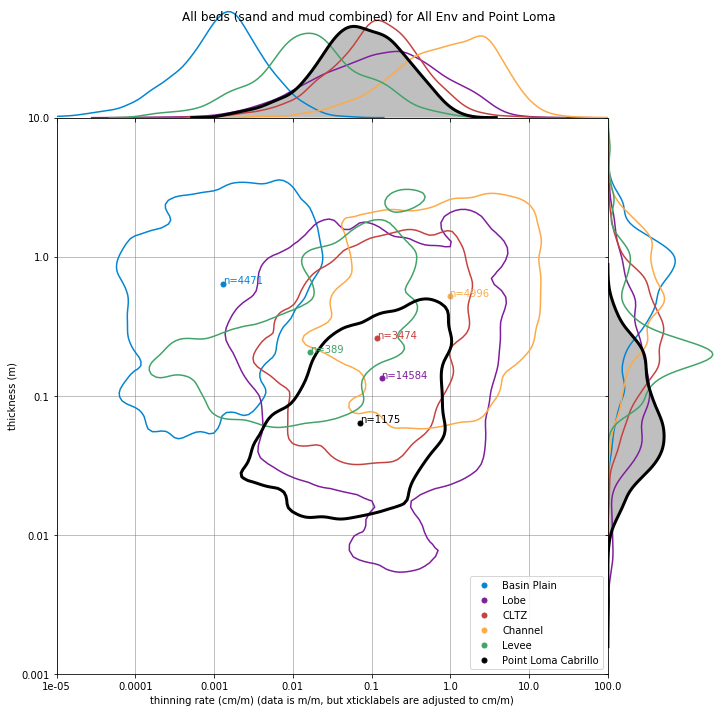

In [4]:
xlab="thinning rate (cm/m) (data is m/m, but xticklabels are adjusted to cm/m)"
ylab="thickness (m)"
colors = ["xkcd:cerulean", "xkcd:purple" , "xkcd:reddish", "xkcd:light orange", "xkcd:greenish"]

g = sns.JointGrid("logtr", "logth", db, height=10, space=0)

for env, values in db.groupby("env_num"):
    env=int(env) # need to convert from float to integer
    # plot the marginal KDEs for x and y
    sns.kdeplot(values["logtr"], ax=g.ax_marg_x, color=colors[env], shade=False, legend=False)
    sns.kdeplot(values["logth"], ax=g.ax_marg_y, color=colors[env], vertical=True, shade=False, legend=False)
    # plot the median values
    g.ax_joint.scatter(values["logtr"].median(),values["logth"].median(), color=colors[env], s=25)
    g.ax_joint.text(values["logtr"].median(),values["logth"].median(),'n='+ str(len(values["logth"])),color=colors[env])
    # now plot the 2D contour map of 90% contour
    density_contour.bivar_kde_contour(values["logtr"], values["logth"], frac=0.9, ax=g.ax_joint, color=colors[env])

# now plot point loma data on top
sns.kdeplot(pl.logtr, ax=g.ax_marg_x, color='k', shade=True, legend=False,linewidth=3)
sns.kdeplot(pl.logth, ax=g.ax_marg_y, color='k', vertical=True, shade=True, legend=False,linewidth=3)
g.ax_joint.scatter(pl.logtr.median(),pl.logth.median(), color='k', s=25)
g.ax_joint.text(pl.logtr.median(),pl.logth.median(), 'n='+ str(len(pl.logth)), color='k')
density_contour.bivar_kde_contour(pl.logtr,pl.logth, frac=0.9, ax=g.ax_joint, color='k',linewidths=3)

# clean up     
xlim=[-7,0]
ylim=[-3,1]
g.fig.suptitle('All beds (sand and mud combined) for All Env and Point Loma')
g.ax_joint.legend(['Basin Plain','Lobe','CLTZ','Channel','Levee','Point Loma Cabrillo'],loc='lower right') #not the best way, but it works
g.ax_joint.set_xlim(xlim)
g.ax_joint.set_ylim(ylim)
g.ax_joint.grid(color='grey', linestyle='-', linewidth=0.5)  
g.ax_joint.set_xlabel(xlab) 
g.ax_joint.set_ylabel(ylab) 
xtick=np.arange(xlim[0],xlim[1]+1,1)
g.ax_joint.set_xticks(xtick) 
xticklabel=np.arange(xlim[0]+2,xlim[1]+3,1) # add 2 (i.e., 100 in log space) to each to convert m/m to cm/m
xticklabel=xticklabel.astype(float)
g.ax_joint.set_xticklabels(np.power(10,xticklabel)) 
ytick=np.arange(ylim[0],ylim[1]+1,1)
g.ax_joint.set_yticks(ytick) 
yticklabel=np.arange(ylim[0],ylim[1]+1,1) 
yticklabel=yticklabel.astype(float)
g.ax_joint.set_yticklabels(np.power(10,yticklabel));

### Sand beds only

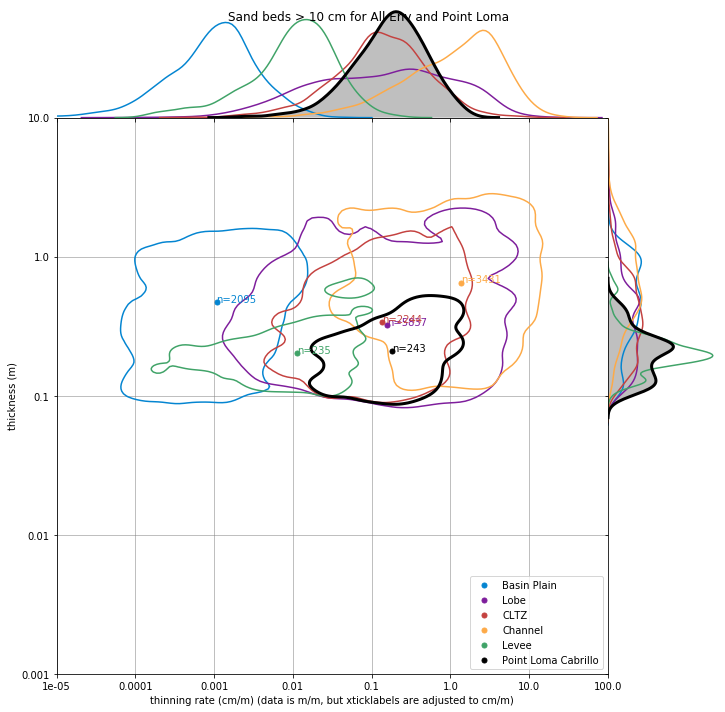

In [5]:
xlab="thinning rate (cm/m) (data is m/m, but xticklabels are adjusted to cm/m)"
ylab="thickness (m)"
g = sns.JointGrid("logtr", "logth", db, height=10, space=0)

for env, values in db.groupby("env_num"):
    env=int(env) # need to convert from float to integer
    values=values[values['lith']==1] # SAND ONLY 
    values=values[values['th']>0.1]
    # plot the marginal KDEs for x and y
    sns.kdeplot(values["logtr"], ax=g.ax_marg_x, color=colors[env], shade=False, legend=False)
    sns.kdeplot(values["logth"], ax=g.ax_marg_y, color=colors[env], vertical=True, shade=False, legend=False)
    # plot the median values
    g.ax_joint.scatter(values["logtr"].median(),values["logth"].median(), color=colors[env], s=25)
    g.ax_joint.text(values["logtr"].median(),values["logth"].median(),'n='+ str(len(values["logth"])),color=colors[env])
    # now plot the 2D contour map of 90% contour
    density_contour.bivar_kde_contour(values["logtr"], values["logth"], frac=0.9, ax=g.ax_joint, color=colors[env])

# now plot point loma data on top
pls01=pl.loc[pl['lith']==1]
pls01=pls01.loc[pl['th']>0.1]
sns.kdeplot(pls01.logtr, ax=g.ax_marg_x, color='k', shade=True, legend=False,linewidth=3)
sns.kdeplot(pls01.logth, ax=g.ax_marg_y, color='k', vertical=True, shade=True, legend=False,linewidth=3)
g.ax_joint.scatter(pls01.logtr.median(),pls01.logth.median(), color='k', s=25)
g.ax_joint.text(pls01.logtr.median(),pls01.logth.median(), 'n='+ str(len(pls01.logth)), color='k')
density_contour.bivar_kde_contour(pls01.logtr,pls01.logth, frac=0.9, ax=g.ax_joint, color='k',linewidths=3)

# clean up     
xlim=[-7,0]
ylim=[-3,1]
g.fig.suptitle('Sand beds > 10 cm for All Env and Point Loma')
g.ax_joint.legend(['Basin Plain','Lobe','CLTZ','Channel','Levee','Point Loma Cabrillo'],loc='lower right') #not the best way, but it works
g.ax_joint.set_xlim(xlim)
g.ax_joint.set_ylim(ylim)
g.ax_joint.grid(color='grey', linestyle='-', linewidth=0.5)  
g.ax_joint.set_xlabel(xlab) 
g.ax_joint.set_ylabel(ylab) 
xtick=np.arange(xlim[0],xlim[1]+1,1)
g.ax_joint.set_xticks(xtick) 
xticklabel=np.arange(xlim[0]+2,xlim[1]+3,1) # add 2 (i.e., 100 in log space) to each to convert m/m to cm/m
xticklabel=xticklabel.astype(float)
g.ax_joint.set_xticklabels(np.power(10,xticklabel)) 
ytick=np.arange(ylim[0],ylim[1]+1,1)
g.ax_joint.set_yticks(ytick) 
yticklabel=np.arange(ylim[0],ylim[1]+1,1) 
yticklabel=yticklabel.astype(float)
g.ax_joint.set_yticklabels(np.power(10,yticklabel));

### Mud 'beds' only

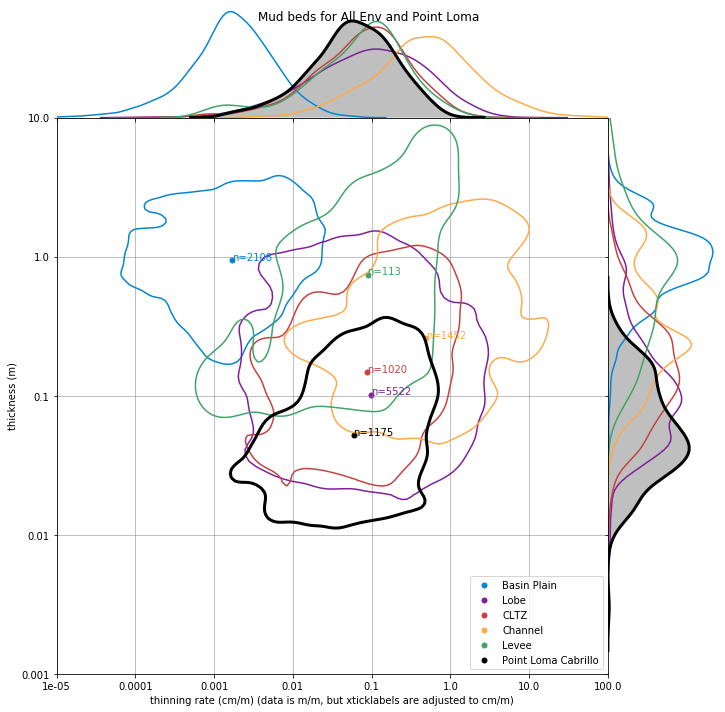

In [6]:
xlab="thinning rate (cm/m) (data is m/m, but xticklabels are adjusted to cm/m)"
ylab="thickness (m)"
g = sns.JointGrid("logtr", "logth", db, height=10, space=0)

for env, values in db.groupby("env_num"):
    env=int(env) # need to convert from float to integer
    values=values[values['lith']==0] # SAND ONLY 
    #values=values[values['th']>0.1]
    # plot the marginal KDEs for x and y
    sns.kdeplot(values["logtr"], ax=g.ax_marg_x, color=colors[env], shade=False, legend=False)
    sns.kdeplot(values["logth"], ax=g.ax_marg_y, color=colors[env], vertical=True, shade=False, legend=False)
    # plot the median values
    g.ax_joint.scatter(values["logtr"].median(),values["logth"].median(), color=colors[env], s=25)
    g.ax_joint.text(values["logtr"].median(),values["logth"].median(),'n='+ str(len(values["logth"])),color=colors[env])
    # now plot the 2D contour map of 90% contour
    density_contour.bivar_kde_contour(values["logtr"], values["logth"], frac=0.9, ax=g.ax_joint, color=colors[env])

# now plot point loma data on top
pls01=pl.loc[pl['lith']==0]
#pls01=pls01.loc[pl['th']>0.1]
sns.kdeplot(pls01.logtr, ax=g.ax_marg_x, color='k', shade=True, legend=False,linewidth=3)
sns.kdeplot(pls01.logth, ax=g.ax_marg_y, color='k', vertical=True, shade=True, legend=False,linewidth=3)
g.ax_joint.scatter(pls01.logtr.median(),pls01.logth.median(), color='k', s=25)
g.ax_joint.text(pls01.logtr.median(),pls01.logth.median(), 'n='+ str(len(pl.logth)), color='k')
density_contour.bivar_kde_contour(pls01.logtr,pls01.logth, frac=0.9, ax=g.ax_joint, color='k',linewidths=3)

# clean up     
xlim=[-7,0]
ylim=[-3,1]
g.fig.suptitle('Mud beds for All Env and Point Loma')
g.ax_joint.legend(['Basin Plain','Lobe','CLTZ','Channel','Levee','Point Loma Cabrillo'],loc='lower right') #not the best way, but it works
g.ax_joint.set_xlim(xlim)
g.ax_joint.set_ylim(ylim)
g.ax_joint.grid(color='grey', linestyle='-', linewidth=0.5)  
g.ax_joint.set_xlabel(xlab) 
g.ax_joint.set_ylabel(ylab) 
xtick=np.arange(xlim[0],xlim[1]+1,1)
g.ax_joint.set_xticks(xtick) 
xticklabel=np.arange(xlim[0]+2,xlim[1]+3,1) # add 2 (i.e., 100 in log space) to each to convert m/m to cm/m
xticklabel=xticklabel.astype(float)
g.ax_joint.set_xticklabels(np.power(10,xticklabel)) 
ytick=np.arange(ylim[0],ylim[1]+1,1)
g.ax_joint.set_yticks(ytick) 
yticklabel=np.arange(ylim[0],ylim[1]+1,1) 
yticklabel=yticklabel.astype(float)
g.ax_joint.set_yticklabels(np.power(10,yticklabel));

## Lobe confinement (Fryer and Jobe 2019)

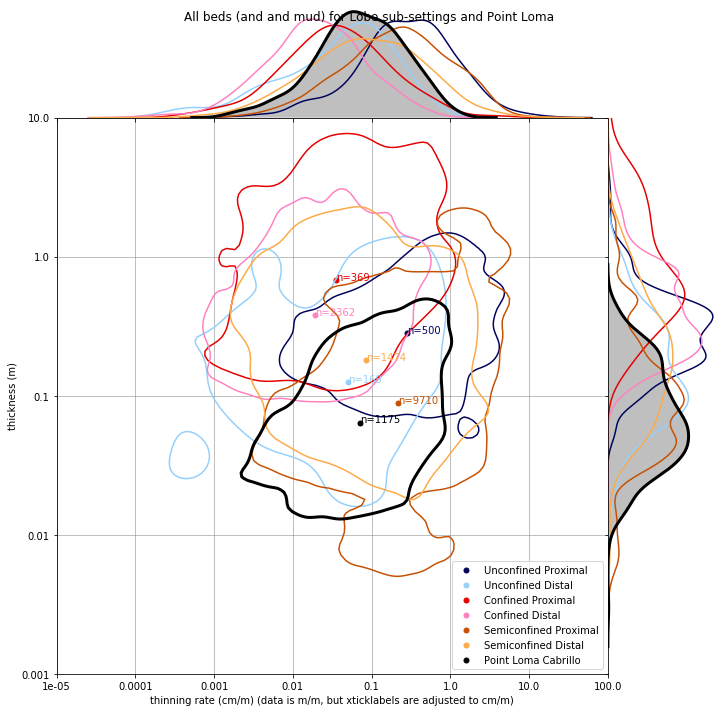

In [7]:
xlab="thinning rate (cm/m) (data is m/m, but xticklabels are adjusted to cm/m)"
ylab="thickness (m)"

lobe=db.loc[db['enviro']=='Lobe']
colors = ["xkcd:dark blue", "xkcd:light blue", "xkcd:red", "xkcd:pink", "xkcd:dark orange", "xkcd:light orange", ]

g = sns.JointGrid("logtr", "logth", lobe, height=10, space=0)

for confinement, values in lobe.groupby("confinement"):
    cnf=confinement-1 # need to subtract 1 because it starts with 1 instead of zero
    # plot the marginal KDEs for x and y
    sns.kdeplot(values["logtr"], ax=g.ax_marg_x, color=colors[cnf], shade=False, legend=False)
    sns.kdeplot(values["logth"], ax=g.ax_marg_y, color=colors[cnf], vertical=True, shade=False, legend=False)
    # plot the median values
    g.ax_joint.scatter(values["logtr"].median(),values["logth"].median(), color=colors[cnf], s=25)
    g.ax_joint.text(values["logtr"].median(),values["logth"].median(),'n='+ str(len(values["logth"])),color=colors[cnf])
    # now plot the 2D contour map of 90% contour
    density_contour.bivar_kde_contour(values["logtr"], values["logth"], frac=0.9, ax=g.ax_joint, color=colors[cnf])

# now plot point loma data on top
sns.kdeplot(pl.logtr, ax=g.ax_marg_x, color='k', shade=True, legend=False,linewidth=3)
sns.kdeplot(pl.logth, ax=g.ax_marg_y, color='k', vertical=True, shade=True, legend=False,linewidth=3)
g.ax_joint.scatter(pl.logtr.median(),pl.logth.median(), color='k', s=25)
g.ax_joint.text(pl.logtr.median(),pl.logth.median(), 'n='+ str(len(pl.logth)), color='k')
density_contour.bivar_kde_contour(pl.logtr,pl.logth, frac=0.9, ax=g.ax_joint, color='k',linewidths=3)

# clean up     
xlim=[-7,0]
ylim=[-3,1]
g.fig.suptitle('All beds (and and mud) for Lobe sub-settings and Point Loma')
g.ax_joint.legend(['Unconfined Proximal','Unconfined Distal','Confined Proximal','Confined Distal','Semiconfined Proximal','Semiconfined Distal','Point Loma Cabrillo'],loc='lower right') #not the best way, but it works
g.ax_joint.set_xlim(xlim)
g.ax_joint.set_ylim(ylim)
g.ax_joint.grid(color='grey', linestyle='-', linewidth=0.5)  
g.ax_joint.set_xlabel(xlab) 
g.ax_joint.set_ylabel(ylab) 
xtick=np.arange(xlim[0],xlim[1]+1,1)
g.ax_joint.set_xticks(xtick) 
xticklabel=np.arange(xlim[0]+2,xlim[1]+3,1) # add 2 (i.e., 100 in log space) to each to convert m/m to cm/m
xticklabel=xticklabel.astype(float)
g.ax_joint.set_xticklabels(np.power(10,xticklabel)) 
ytick=np.arange(ylim[0],ylim[1]+1,1)
g.ax_joint.set_yticks(ytick) 
yticklabel=np.arange(ylim[0],ylim[1]+1,1) 
yticklabel=yticklabel.astype(float)
g.ax_joint.set_yticklabels(np.power(10,yticklabel));

## Thinning Rate vs Distance (Fryer and Jobe, 2019)

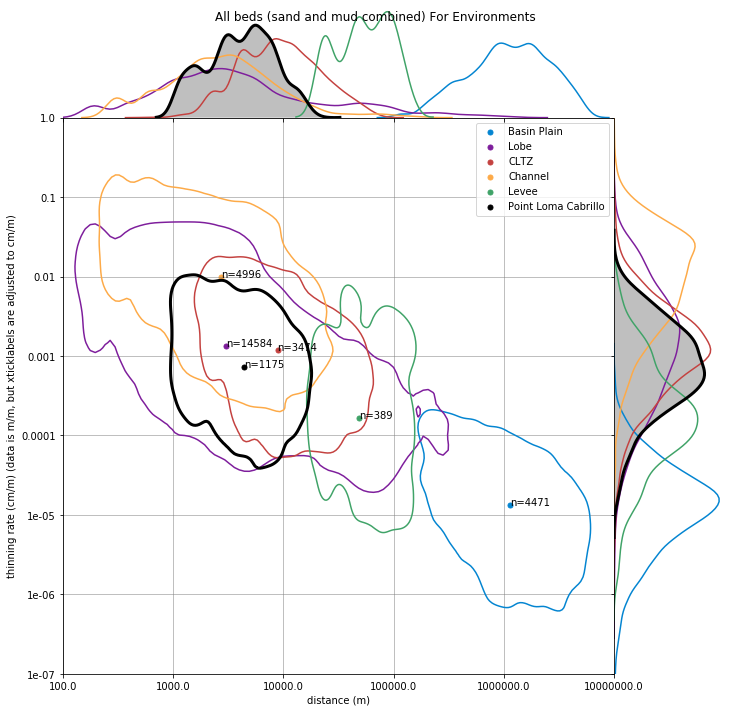

In [8]:
xlab="distance (m)"
ylab="thinning rate (cm/m) (data is m/m, but xticklabels are adjusted to cm/m)"
colors = ["xkcd:cerulean", "xkcd:purple" , "xkcd:reddish", "xkcd:light orange", "xkcd:greenish"]

g = sns.JointGrid("logdist", "logtr", db, height=10, space=0)

for env, values in db.groupby("env_num"):
    env=int(env)
    # plot the marginal KDEs for x and y
    sns.kdeplot(values["logdist"], ax=g.ax_marg_x, color=colors[env], shade=False, legend=False)
    sns.kdeplot(values["logtr"], ax=g.ax_marg_y, color=colors[env], vertical=True, shade=False, legend=False)
    # plot the median values
    g.ax_joint.scatter(values["logdist"].median(),values["logtr"].median(), color=colors[env], s=25)
    g.ax_joint.text(values["logdist"].median(),values["logtr"].median(),'n='+ str(len(values["logtr"])))
    # now plot the 2D contour map of 90% contour
    density_contour.bivar_kde_contour(values["logdist"], values["logtr"], frac=0.9, ax=g.ax_joint, color=colors[env])

# now plot point loma data on top
sns.kdeplot(pl.logdist, ax=g.ax_marg_x, color='k', shade=True, legend=False,linewidth=3)
sns.kdeplot(pl.logtr, ax=g.ax_marg_y, color='k', vertical=True, shade=True, legend=False,linewidth=3)
g.ax_joint.scatter(pl.logdist.median(),pl.logtr.median(), color='k', s=25)
g.ax_joint.text(pl.logdist.median(),pl.logtr.median(), 'n='+ str(len(pl.logtr)), color='k')
density_contour.bivar_kde_contour(pl.logdist,pl.logtr, frac=0.9, ax=g.ax_joint, color='k',linewidths=3)

# clean up     
g.fig.suptitle('All beds (sand and mud combined) For Environments')
xlim=[0,5]
ylim=[-7,0]
g.ax_joint.legend(['Basin Plain','Lobe','CLTZ','Channel','Levee','Point Loma Cabrillo'],loc='upper right') 
g.ax_joint.set_xlim(xlim)
g.ax_joint.set_ylim(ylim)
g.ax_joint.grid(color='grey', linestyle='-', linewidth=0.5)  
g.ax_joint.set_xlabel(xlab) 
g.ax_joint.set_ylabel(ylab) 
xtick=np.arange(xlim[0],xlim[1]+1,1)
g.ax_joint.set_xticks(xtick) 
xticklabel=np.arange(xlim[0]+2,xlim[1]+3,1) # add 2 (i.e., 100 in log space) to each to convert m/m to cm/m
xticklabel=xticklabel.astype(float)
g.ax_joint.set_xticklabels(np.power(10,xticklabel)) 
ytick=np.arange(ylim[0],ylim[1]+1,1)
g.ax_joint.set_yticks(ytick) 
yticklabel=np.arange(ylim[0],ylim[1]+1,1) 
yticklabel=yticklabel.astype(float)
g.ax_joint.set_yticklabels(np.power(10,yticklabel));

## KDEs of 1D distributions comparing database to Point Loma

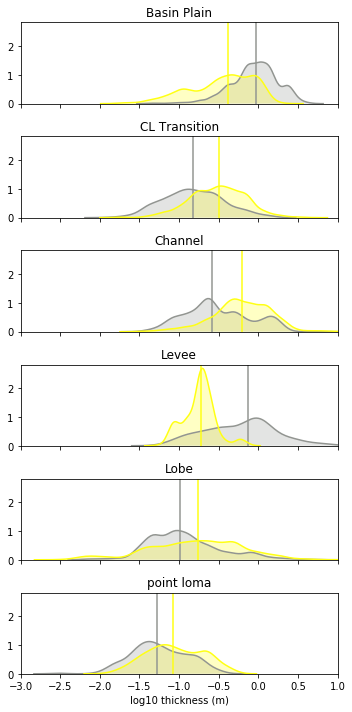

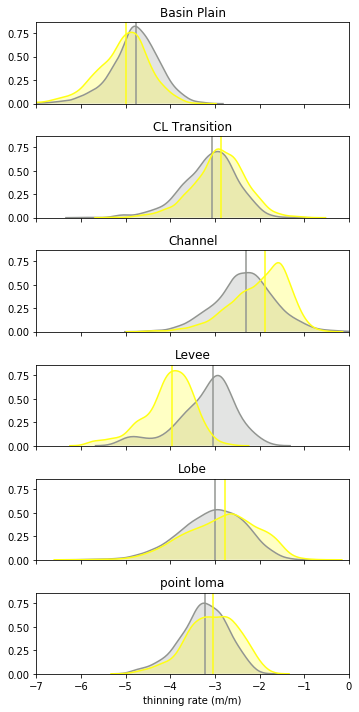

In [34]:
fig, axs = plt.subplots(6,figsize=(5, 10),sharex=True,sharey=True)
plt.setp(axs, xlim=[-3,1]) # set up x axis
xlab="log10 thickness (m)"

def plot_KDE(sand, mud, axis):
    sns.distplot(mud, hist=False, color="xkcd:grey", kde_kws={"shade": True}, ax=axis)
    axis.axvline(np.median(mud), color="xkcd:grey")
    sns.distplot(sand, hist=False, color="xkcd:yellow", kde_kws={"shade": True}, ax=axis)
    axis.axvline(np.median(sand), color="xkcd:yellow")
    return(axis)

num=0
for env, values in db.groupby("enviro"):
    axis=axs[num]
    sand=values["logth"][values["lith"] == 1]
    mud=values["logth"][values["lith"] == 0]
    plot_KDE(sand, mud, axis)
    axis.set_title(env)
    axis.set_xlabel('')
    num+=1
    
plot_KDE(pl.logth[pl.lith == 1],pl.logth[pl.lith == 0],axs[num])
axs[num].set_title("point loma")
axs[num].set_xlabel(xlab) 

plt.tight_layout()
plt.savefig("./saved plots/Environments compared to point loma thickness" + ".pdf", transparent=True)

########### now thinning rate

fig, axs = plt.subplots(6,figsize=(5, 10),sharex=True,sharey=True)
plt.setp(axs, xlim=[-7,0]) # set up x axis
xlab="thinning rate (m/m)"

num=0
for env, values in db.groupby("enviro"):
    axis=axs[num]
    sand=values["logtr"][values["lith"] == 1]
    mud=values["logtr"][values["lith"] == 0]
    plot_KDE(sand, mud, axis)
    axis.set_title(env)
    axis.set_xlabel('')
    num+=1

plot_KDE(pl.logtr[pl.lith == 1],pl.logtr[pl.lith == 0],axs[num])
axs[num].set_title("point loma")
axs[num].set_xlabel(xlab) 

plt.tight_layout()
plt.savefig("./saved plots/Environments compared to point loma thinning rate" + ".pdf", transparent=True)


## And now for comparing Lobe sub environments to Point Loma

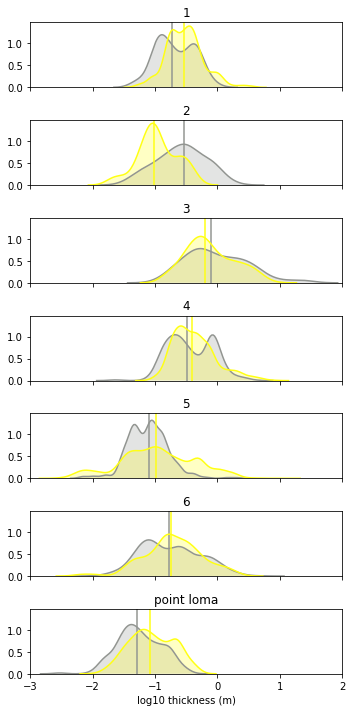

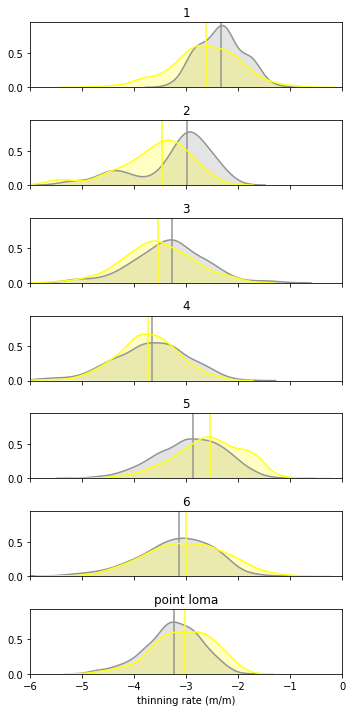

In [35]:
lobes = db[db.enviro == 'Lobe']

fig, axs = plt.subplots(7,figsize=(5, 10),sharex=True,sharey=True)
plt.setp(axs, xlim=[-3,2]) # set up x axis
xlab="log10 thickness (m)"

num=0
for conf, values in lobes.groupby("confinement"):
    axis=axs[num]
    sand=values["logth"][values["lith"] == 1]
    mud=values["logth"][values["lith"] == 0]
    plot_KDE(sand, mud, axis)
    axis.set_title(conf)
    axis.set_xlabel('')
    num+=1
    
plot_KDE(pl.logth[pl.lith == 1],pl.logth[pl.lith == 0],axs[num])
axs[num].set_title("point loma")
axs[num].set_xlabel(xlab) 

plt.tight_layout()
plt.savefig("./saved plots/Lobe sub environments and point loma thickness" + ".pdf", transparent=True)

########### now thinning rate

fig, axs = plt.subplots(7,figsize=(5, 10),sharex=True,sharey=True)
plt.setp(axs, xlim=[-6,0]) # set up x axis
xlab="thinning rate (m/m)"

num=0
for conf, values in lobes.groupby("confinement"):
    axis=axs[num]
    sand=values["logtr"][values["lith"] == 1]
    mud=values["logtr"][values["lith"] == 0]
    plot_KDE(sand, mud, axis)
    axis.set_title(conf)
    axis.set_xlabel('')
    num+=1

plot_KDE(pl.logtr[pl.lith == 1],pl.logtr[pl.lith == 0],axs[num])
axs[num].set_title("point loma")
axs[num].set_xlabel(xlab) 

plt.tight_layout()
plt.savefig("./saved plots/Lobe sub environments and point loma thinning rate" + ".pdf", transparent=True)
